In [35]:
import numpy as np
import matplotlib.pyplot as plt

**Generate a Two-Circle Dataset **

In [36]:
def generate_circles(n_samples=200, noise=0.15, factor=0.5, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)

    n_samples_out = n_samples // 2
    n_samples_in = n_samples - n_samples_out

    theta_out = 2 * np.pi * np.random.rand(n_samples_out)
    r_out = 1.0 + noise * np.random.randn(n_samples_out)
    outer_x = r_out * np.cos(theta_out)
    outer_y = r_out * np.sin(theta_out)


    theta_in = 2 * np.pi * np.random.rand(n_samples_in)
    r_in = factor + noise * np.random.randn(n_samples_in)
    inner_x = r_in * np.cos(theta_in)
    inner_y = r_in * np.sin(theta_in)

    X = np.vstack([np.concatenate([outer_x, inner_x]),
                   np.concatenate([outer_y, inner_y])]).T
    y = np.hstack([np.ones(n_samples_out), -np.ones(n_samples_in)])

    return X, y



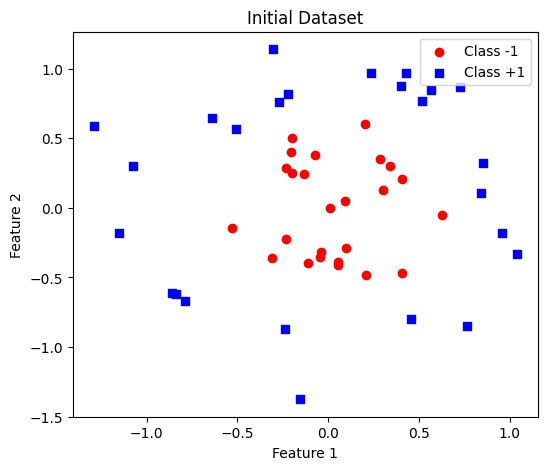

In [37]:
    # Generate a complex two-circle dataset with noise
X, y = generate_circles(n_samples=50, noise=0.15, factor=0.4, random_state=42)

# Plot the initial dataset
plt.figure(figsize=(6, 5))
plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], c='red', marker='o', label="Class -1")
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], c='blue', marker='s', label="Class +1")
plt.title("Initial Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

 Implement AdaBoost using Decision Stump

In [38]:
class DecisionStump:
    def __init__(self):
        self.feature_index = None  # Index of the feature to split on
        self.threshold = None      # Threshold value for the split
        self.polarity = 1          # Determines the direction of the inequality (1 or -1)

    def predict(self, X):
        n_samples = X.shape[0]
        # Start by predicting all samples as +1
        predictions = np.ones(n_samples)
        if self.polarity == 1:
            predictions[X[:, self.feature_index] < self.threshold] = -1
        else:
            predictions[X[:, self.feature_index] >= self.threshold] = -1
        return predictions


In [39]:

def train_decision_stump(X, y, weights):
    n_samples, n_features = X.shape
    best_stump = DecisionStump()
    min_error = float('inf')

    # Loop through each feature and each unique value as a candidate threshold
    for feature_i in range(n_features):
        feature_values = X[:, feature_i]
        unique_values = np.unique(feature_values)
        for threshold in unique_values:
            for polarity in [1, -1]:
                stump = DecisionStump()
                stump.feature_index = feature_i
                stump.threshold = threshold
                stump.polarity = polarity

                predictions = np.ones(n_samples)
                if polarity == 1:
                    predictions[feature_values < threshold] = -1
                else:
                    predictions[feature_values >= threshold] = -1

                # Compute the weighted error
                error = np.sum(weights[y != predictions])

                if error < min_error:
                    min_error = error
                    best_stump = stump
    return best_stump, min_error


In [40]:

class AdaBoost:
    def __init__(self, n_clf=10):
        self.n_clf = n_clf        # Number of weak classifiers
        self.clfs = []            # List to store the weak classifiers
        self.clf_weights = []     # List to store the weight (alpha) for each classifier

    def fit(self, X, y, plot_progress=False):
        n_samples, n_features = X.shape
        # Initialize sample weights equally
        weights = np.full(n_samples, 1 / n_samples)

        self.clfs = []
        self.clf_weights = []

        if plot_progress:
            plt.ion()  # Turn on interactive mode for plotting

        # Train weak classifiers
        for t in range(self.n_clf):
            stump, error = train_decision_stump(X, y, weights)
            eps = 1e-10  # Small constant to prevent division by zero
            alpha = 0.5 * np.log((1 - error + eps) / (error + eps))

            predictions = stump.predict(X)
            # Update weights: increase weights for misclassified samples
            weights *= np.exp(-alpha * y * predictions)
            weights /= np.sum(weights)  # Normalize weights

            self.clfs.append(stump)
            self.clf_weights.append(alpha)

            # Plot the current decision boundary if requested
            if plot_progress:
                self._plot_intermediate(X, y, iteration=t+1)

        if plot_progress:
            plt.ioff()  # Turn off interactive mode
            plt.show()

    def predict(self, X):
        # Compute weighted sum of predictions from all weak classifiers
        clf_preds = np.array([alpha * clf.predict(X) for clf, alpha in zip(self.clfs, self.clf_weights)])
        y_pred = np.sign(np.sum(clf_preds, axis=0))
        return y_pred

    def _plot_intermediate(self, X, y, iteration):
        # Define the range for plotting
        x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

        # Create a mesh grid
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                             np.linspace(y_min, y_max, 300))
        grid = np.c_[xx.ravel(), yy.ravel()]

        # Calculate the current weighted predictions for the grid
        clf_preds = np.array([alpha * clf.predict(grid) for clf, alpha in zip(self.clfs, self.clf_weights)])
        Z = np.sign(np.sum(clf_preds, axis=0))
        Z = Z.reshape(xx.shape)

        plt.clf()  # Clear the current figure
        plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)
        plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], c='red', marker='o', label="Class -1")
        plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], c='blue', marker='s', label="Class +1")
        plt.title(f"Iteration {iteration}: Current decision boundary")
        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")
        plt.legend()
        plt.draw()
        plt.pause(0.5)



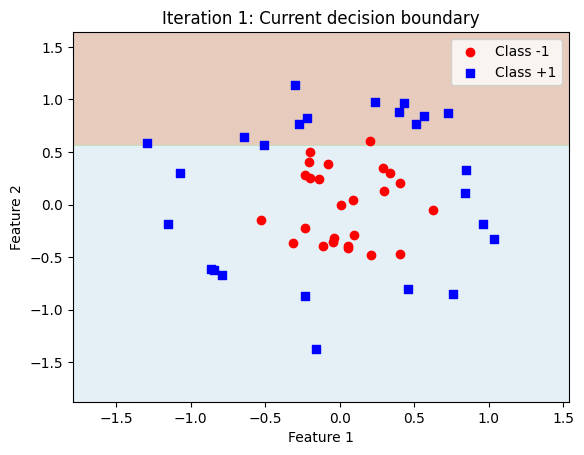

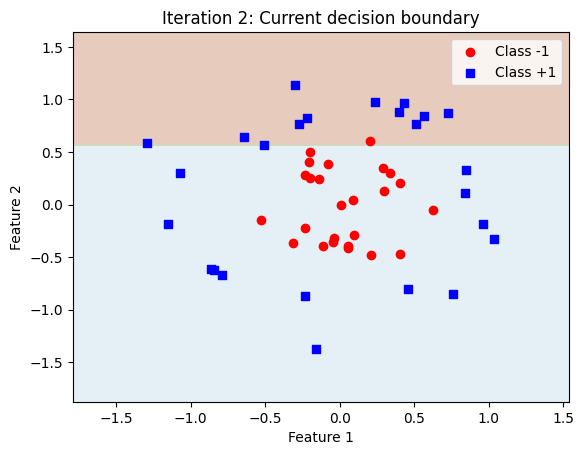

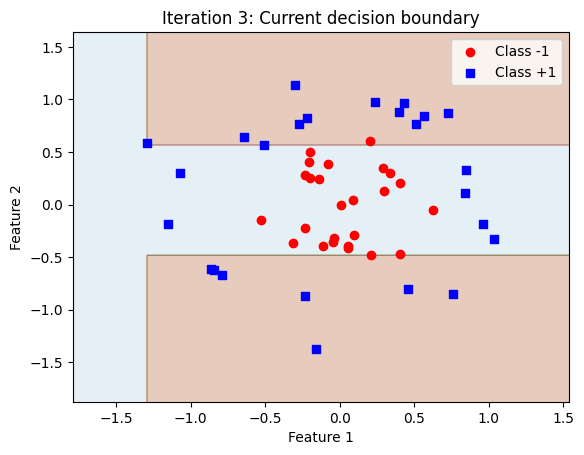

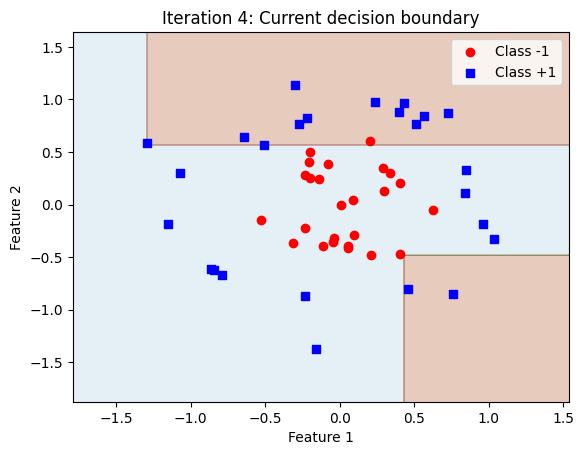

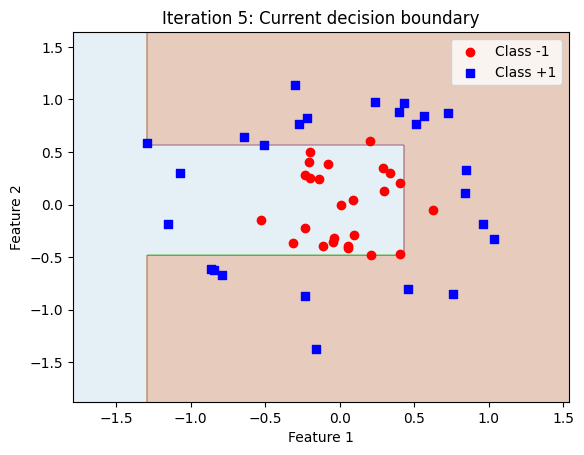

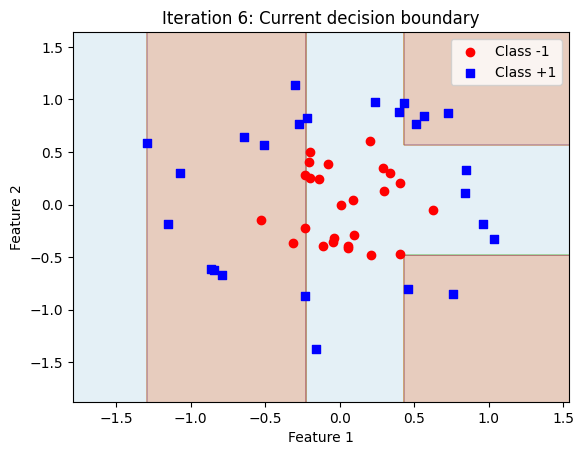

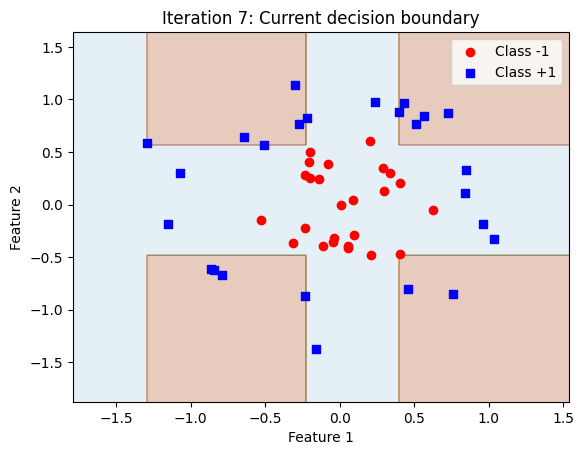

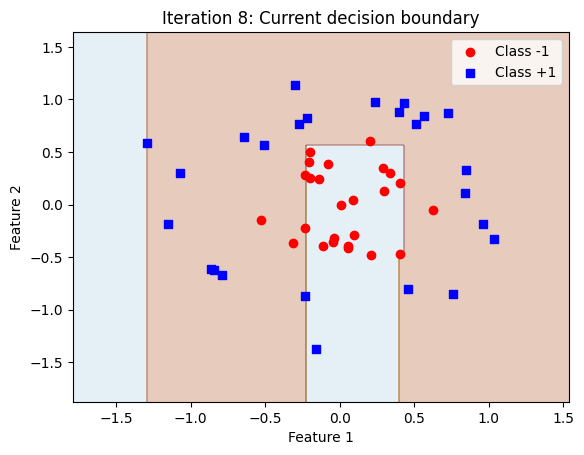

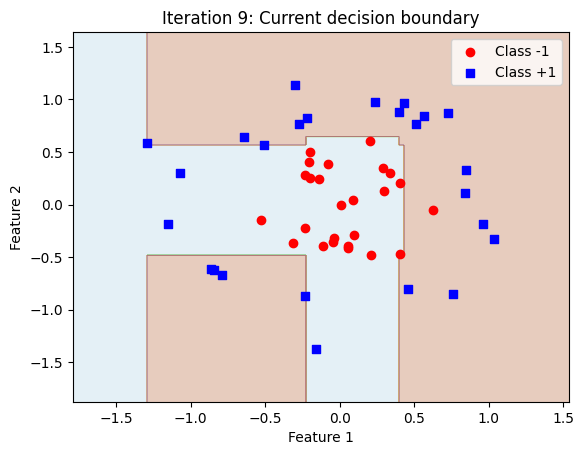

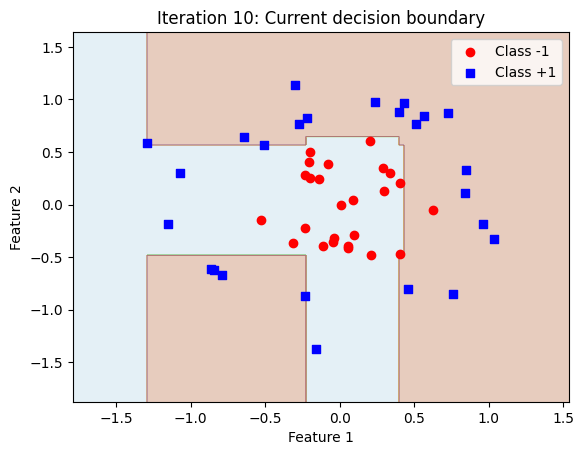

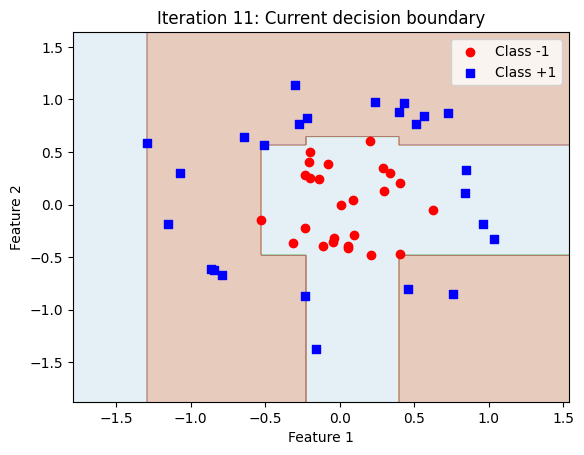

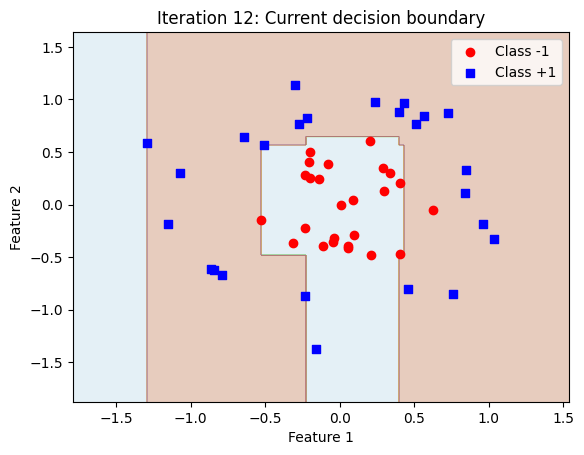

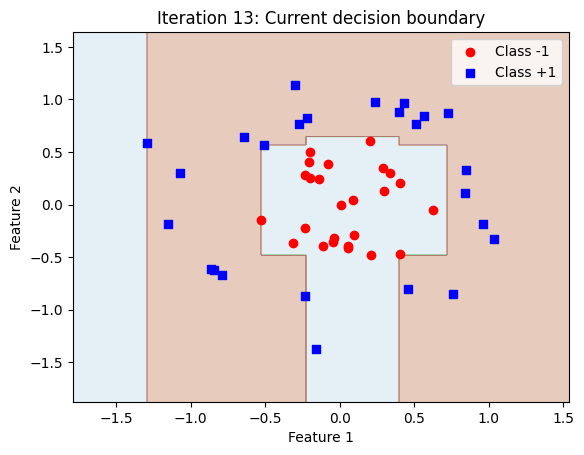

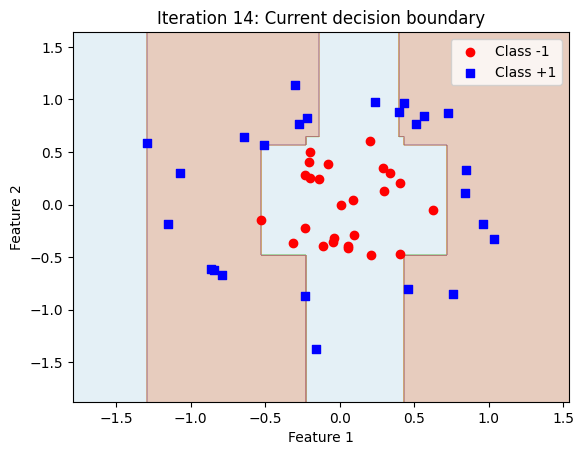

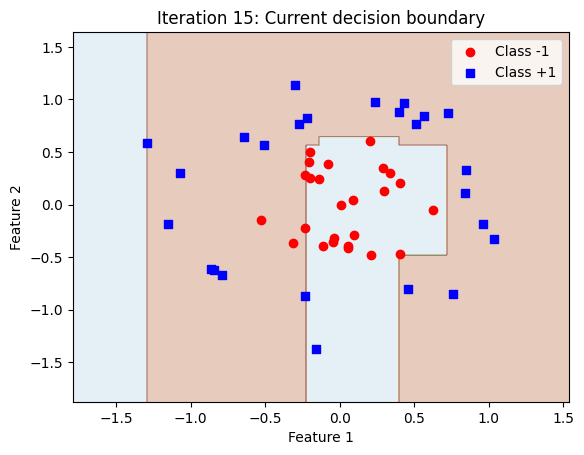

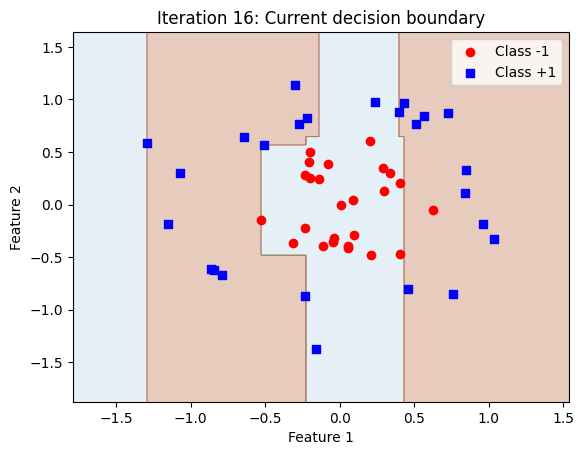

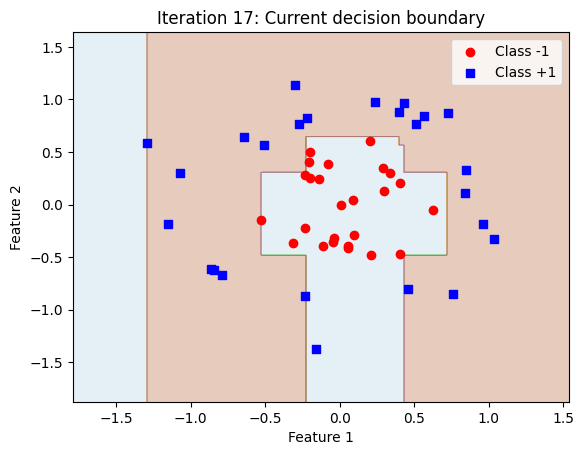

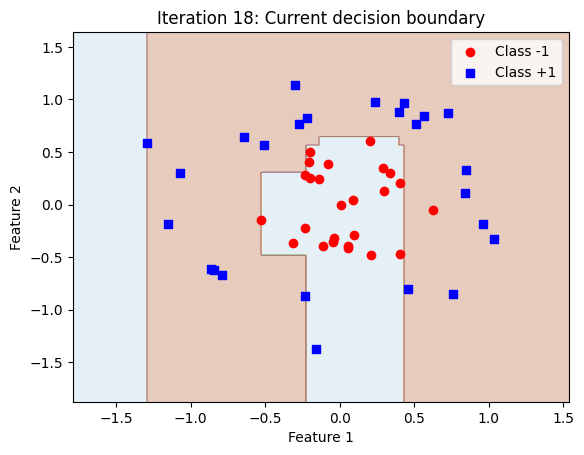

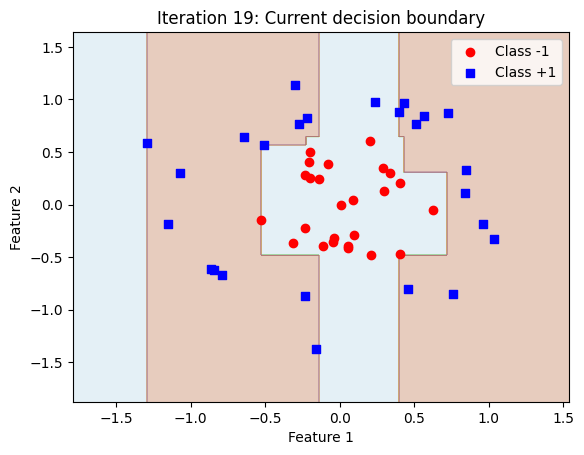

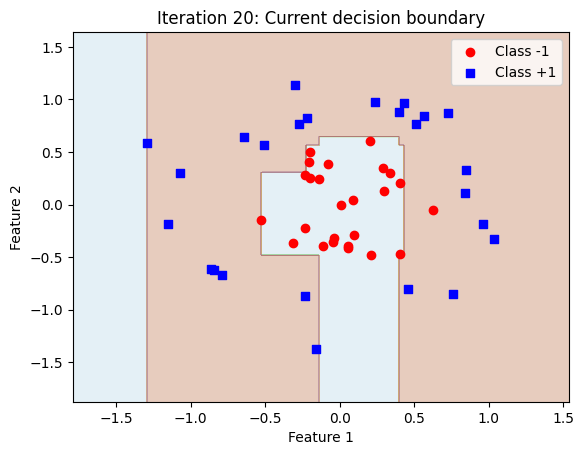

Model accuracy on complex dataset: 98.00%


In [41]:

# Create and train the AdaBoost model while plotting progress
model = AdaBoost(n_clf=20)
model.fit(X, y, plot_progress=True)

# Predict on the training data and calculate accuracy
predictions = model.predict(X)
accuracy = np.sum(predictions == y) / len(y)
print("Model accuracy on complex dataset: {:.2f}%".format(accuracy * 100))
